<a href="https://colab.research.google.com/github/HopeRetina/topic-modeling/blob/main/Topic_modeling_of_Amazon_watch_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
file = drive.CreateFile({'id':'192JMR7SIqoa14vrs7Z9BXO3iK89pimJL'}) # replace the id with id of file you want to access
file.GetContentFile('data.tsv')  # tab-separated

In [3]:
import numpy as np
import pandas as pd
import nltk
# import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load data into dataframe
df = pd.read_csv('data.tsv', sep='\t', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkip

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960197 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


In [6]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [7]:
# Remove missing value
df.dropna(subset=['review_body'],inplace=True)

In [8]:
df.shape

(960056, 15)

In [9]:
df.tail(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
960202,US,44474855,R2MMGPUWXXOFI2,B00004YK0H,118389241,Energizer 393 Button Cell Battery,Watches,4,0,0,N,N,Now watt a minute here.,"In the old days, the common hearing battery in...",2001-04-05
960203,US,44474855,R2BZMVAERMRUDE,B00004YK0H,118389241,Energizer 393 Button Cell Battery,Watches,4,5,7,N,N,1/10 Watt difference for hearing aids,I have found that a #393 watch battery is the ...,2001-04-05


In [10]:
# Reset index
df.reset_index(inplace=True, drop=True)

In [12]:
# use the first 20000 data as training data
data = df.loc[:19999, 'review_body'].tolist()

In [13]:
len(data)

20000

##Tokenizing and stemming

In [15]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') 
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("watch")
#stopwords.append("n't")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


###Write a function to analyze (i.e. tokenize, stem) reviews.

In [17]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [18]:
tokenization_and_stemming(data[77])

['excel', 'product', 'seller', 'good', 'servic']

In [ ]:
data[77]

##TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,2))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  % sorted(inconsistent)


In total, there are 20000 reviews and 242 terms.


In [20]:
tfidf_matrix.shape

(20000, 242)

In [ ]:
tfidf_matrix.toarray() #todense()

In [21]:
tfidf_matrix.todense()

matrix([[0.        , 0.51831081, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [22]:
# words
tf_selected_words = tfidf_model.get_feature_names_out() 

In [23]:
# print out words
tf_selected_words

array(['abl', 'absolut', 'accur', 'actual', 'adjust', 'alarm', 'alreadi',
       'alway', 'amaz', 'amazon', 'anoth', 'anyth', 'appear', 'arriv',
       'attract', 'awesom', 'bad', 'band', 'batteri', 'beauti', 'best',
       'better', 'big', 'birthday', 'bit', 'black', 'blue', 'bought',
       'box', 'bracelet', 'brand', 'break', 'broke', 'button', 'buy',
       'ca', 'came', 'case', 'casio', 'chang', 'cheap', 'clasp', 'classi',
       'clear', 'clock', 'color', 'come', 'comfort', 'compliment', 'cool',
       'cost', 'coupl', 'crystal', 'cute', 'dark', 'date', 'daughter',
       'day', 'deal', 'definit', 'design', 'dial', 'differ', 'difficult',
       'digit', 'disappoint', 'display', 'durabl', 'easi', 'easi read',
       'easili', 'eleg', 'end', 'everi', 'everyday', 'everyth', 'exact',
       'excel', 'expect', 'expens', 'face', 'far', 'fast', 'favorit',
       'featur', 'feel', 'figur', 'fine', 'fit', 'function', 'gave',
       'gift', 'glass', 'goe', 'gold', 'good', 'good look',
    

#K-means Clustering

In [34]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 10

# number of clusters
km = KMeans(n_clusters=num_clusters, random_state=7)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

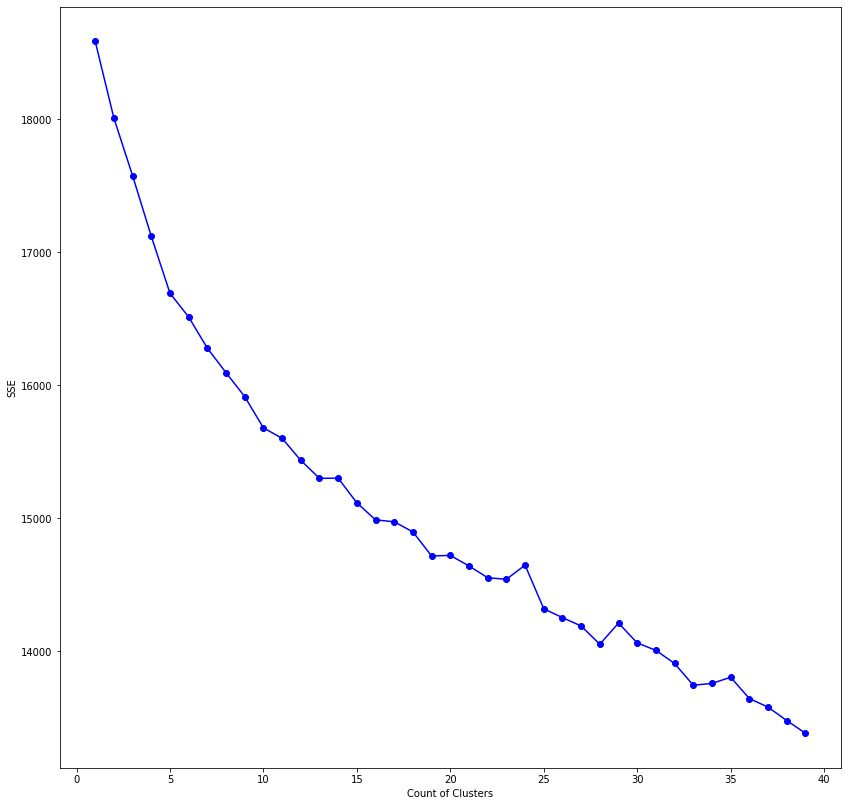

In [28]:
# Now use elbow method to identify a good k

sse = []
for k in range(1, 40):
    km = KMeans(n_clusters=k)
    km.fit(tfidf_matrix)
    sse.append(km.inertia_)

# plot to identify the elbow
plt.figure(figsize=(14, 14))
plt.plot(range(1, 40), sse, '-o', c = 'blue')
plt.xlabel('Count of Clusters')
plt.ylabel('SSE');

##Analyze K-means result

In [35]:
# create DataFrame films from all of the input files.
product = { 'review': df[:20000].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])

In [36]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
0,7051
1,3972
4,1799
7,1544
8,1313
5,1034
9,1017
2,925
3,806
6,539


In [37]:
km.cluster_centers_

array([[0.00429402, 0.00736407, 0.00313153, ..., 0.01026496, 0.01565505,
        0.01501858],
       [0.00686662, 0.00756404, 0.01286463, ..., 0.00841068, 0.02799204,
        0.02319039],
       [0.        , 0.        , 0.00147748, ..., 0.00209805, 0.00582163,
        0.        ],
       ...,
       [0.00729514, 0.00456878, 0.00630611, ..., 0.00745119, 0.05472301,
        0.01500778],
       [0.00284533, 0.0024668 , 0.00317747, ..., 0.00414422, 0.02356967,
        0.01177898],
       [0.        , 0.01020976, 0.00047651, ..., 0.        , 0.00327493,
        0.00265486]])

In [38]:
km.cluster_centers_.shape

(10, 242)

In [39]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews))
    print ()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



##Part 5: Topic Modeling - Latent Dirichlet Allocation

In [61]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components)

In [62]:
# document topic matrix for tfidf_matrix_lda
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(20000, 10)
[[0.02960787 0.47733656 0.02963019 ... 0.0296172  0.02961606 0.2857746 ]
 [0.04147761 0.04148376 0.0414822  ... 0.04148117 0.32069514 0.34747471]
 [0.05       0.54999118 0.05       ... 0.05000286 0.05000556 0.05      ]
 ...
 [0.26015641 0.03678926 0.03678922 ... 0.03679086 0.03679139 0.03678713]
 [0.02102651 0.02103181 0.02102869 ... 0.02103006 0.81073137 0.02102749]
 [0.03105067 0.03105562 0.03105733 ... 0.0310578  0.72049683 0.03106179]]


In [63]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(10, 242)
[[ 0.100004   23.5754593   7.25021105 ...  4.62028549  4.57538071
   0.36218014]
 [ 4.11912917  2.95462628  6.11850295 ... 10.49902901  5.8237796
  58.61326329]
 [ 4.58445677  0.10000884  8.13652424 ...  1.60011154  0.37029528
   3.46594981]
 ...
 [14.90713096 14.58598272 18.33002148 ... 99.62673788 24.0889132
  74.94421357]
 [34.7468748   7.59264126 30.02616966 ... 18.68617575 50.09714295
  54.37099381]
 [ 0.95074929 65.25640202  0.10000179 ...  0.10000356  0.32235845
  40.5086603 ]]


In [43]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,topic
Doc0,0.03,0.53,0.03,0.03,0.23,0.03,0.03,0.03,0.03,0.03,1
Doc1,0.04,0.04,0.63,0.04,0.04,0.04,0.04,0.04,0.04,0.04,2
Doc2,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
Doc3,0.72,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Doc4,0.02,0.02,0.02,0.08,0.02,0.02,0.52,0.02,0.02,0.27,6
Doc5,0.04,0.67,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,1
Doc6,0.03,0.03,0.32,0.03,0.03,0.03,0.03,0.03,0.47,0.03,8
Doc7,0.03,0.72,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1
Doc8,0.42,0.02,0.02,0.02,0.02,0.22,0.02,0.02,0.20,0.02,0
Doc9,0.03,0.75,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,1


In [44]:
df_document_topic['topic'].value_counts().to_frame()

,topic
0,4447
9,2560
6,2549
1,2280
5,1764
8,1592
2,1443
4,1231
7,1126
3,1008


In [46]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names_out()
df_topic_words.index = topic_names

df_topic_words.head()

[[5.74476051e+01 1.36664739e+01 4.98351390e+01 ... 2.95947800e+01
  8.05356355e+01 2.08321450e+02]
 [1.32464653e+00 8.87835416e-01 7.08532495e+00 ... 1.38190351e+01
  1.37643017e+01 9.53728382e+00]
 [1.00012776e-01 2.59677972e+01 1.00001553e-01 ... 1.00004708e-01
  1.00009004e-01 3.02614327e+00]
 ...
 [1.00009084e-01 1.00001612e-01 6.11549388e-01 ... 1.00002874e-01
  1.00002439e-01 1.00003160e-01]
 [1.00004835e-01 1.00004959e-01 2.43246526e+01 ... 8.49098985e+01
  5.14002193e-01 4.84145267e+00]
 [8.56556955e+00 1.00365700e-01 7.54655915e+00 ... 9.77384064e+00
  1.70392096e+00 2.93916705e+01]]


,abl,absolut,accur,actual,adjust,alarm,alreadi,alway,amaz,amazon,...,weight,white,wife,wish,work,work great,worn,worth,wrist,year
Topic0,57.447605,13.666474,49.835139,42.404111,50.059825,53.019879,23.746391,33.084867,11.420725,50.224987,...,15.958538,36.163844,12.548130,41.729178,130.166151,5.168945,68.521532,29.594780,80.535635,208.321450
Topic1,1.324647,0.887835,7.085325,16.457261,2.653046,0.100004,8.882054,63.284548,1.944084,15.906441,...,17.329753,33.287751,17.461381,4.608280,23.474186,0.100003,5.916389,13.819035,13.764302,9.537284
Topic2,0.100013,25.967797,0.100002,0.100046,0.100004,0.100002,0.100016,0.100006,0.100003,0.100033,...,0.100007,0.100003,110.584255,0.100050,0.100320,0.100003,0.100004,0.100005,0.100009,3.026143
Topic3,0.100002,0.100005,0.944621,0.100002,0.100004,0.100000,0.100011,0.100008,0.100001,0.100005,...,0.662612,0.100005,0.100005,0.100004,3.711414,0.100001,0.100001,0.100009,0.100006,0.100006
Topic4,0.100011,81.119135,2.106872,7.818413,0.109673,0.100004,0.100002,0.100013,140.974487,27.407580,...,0.114236,0.100003,0.100016,0.100015,11.064192,0.100006,0.100015,2.064299,3.406516,4.238675


In [47]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names_out())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i+1) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i+1) for i in range(df_topic_words.shape[0])]
df_topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,time,band,year,day,broke,wear,use,hand,look,second,like,watch,work,old,set
Topic 2,like,qualiti,realli,watch,want,look,good,pretti,lot,good qualiti,color,compliment,love,invicta,realli like
Topic 3,love,gift,awesom,husband,bought,wife,cute,son,birthday,daughter,love look,gave,got,look,absolut
Topic 4,nice,ok,nice look,best,look,stylish,price,look nice,compliment,comfort,mani,everyth,buy,realli,expect
Topic 5,amaz,happi,fast,recommend,high,ship,pictur,purchas,pleas,classi,love,better,absolut,beauti,look
Topic 6,perfect,easi,read,cool,use,light,easi read,eleg,time,water,love,set,fit,size,hard
Topic 7,wrist,small,band,big,fit,cheap,littl,expect,look,strap,size,larg,face,link,like
Topic 8,excel,beauti,product,thank,good,item,great,arriv,seller,recommend,qualiti,price,time,quick,favorit
Topic 9,great,price,look,look great,great price,great look,work great,money,valu,work,worth,clock,time,durabl,wear
Topic 10,good,work,batteri,look good,look,time,stop,replac,month,came,need,new,exact,day,receiv


##Try NMF out

In [50]:
from sklearn.decomposition import NMF

# Fit the NMF model
init = 'nndsvda'

nmf = NMF(
    n_components=n_components,
    max_iter=10000,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf_matrix)


##Try NMF with a generalized kullback-leibler divergence

In [71]:
nmf_kl = NMF(
    n_components=n_components,
    max_iter=10000,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver='mu',
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf_matrix)


##Write a function to list the top words in each topic

In [66]:
def list_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='green', alpha=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


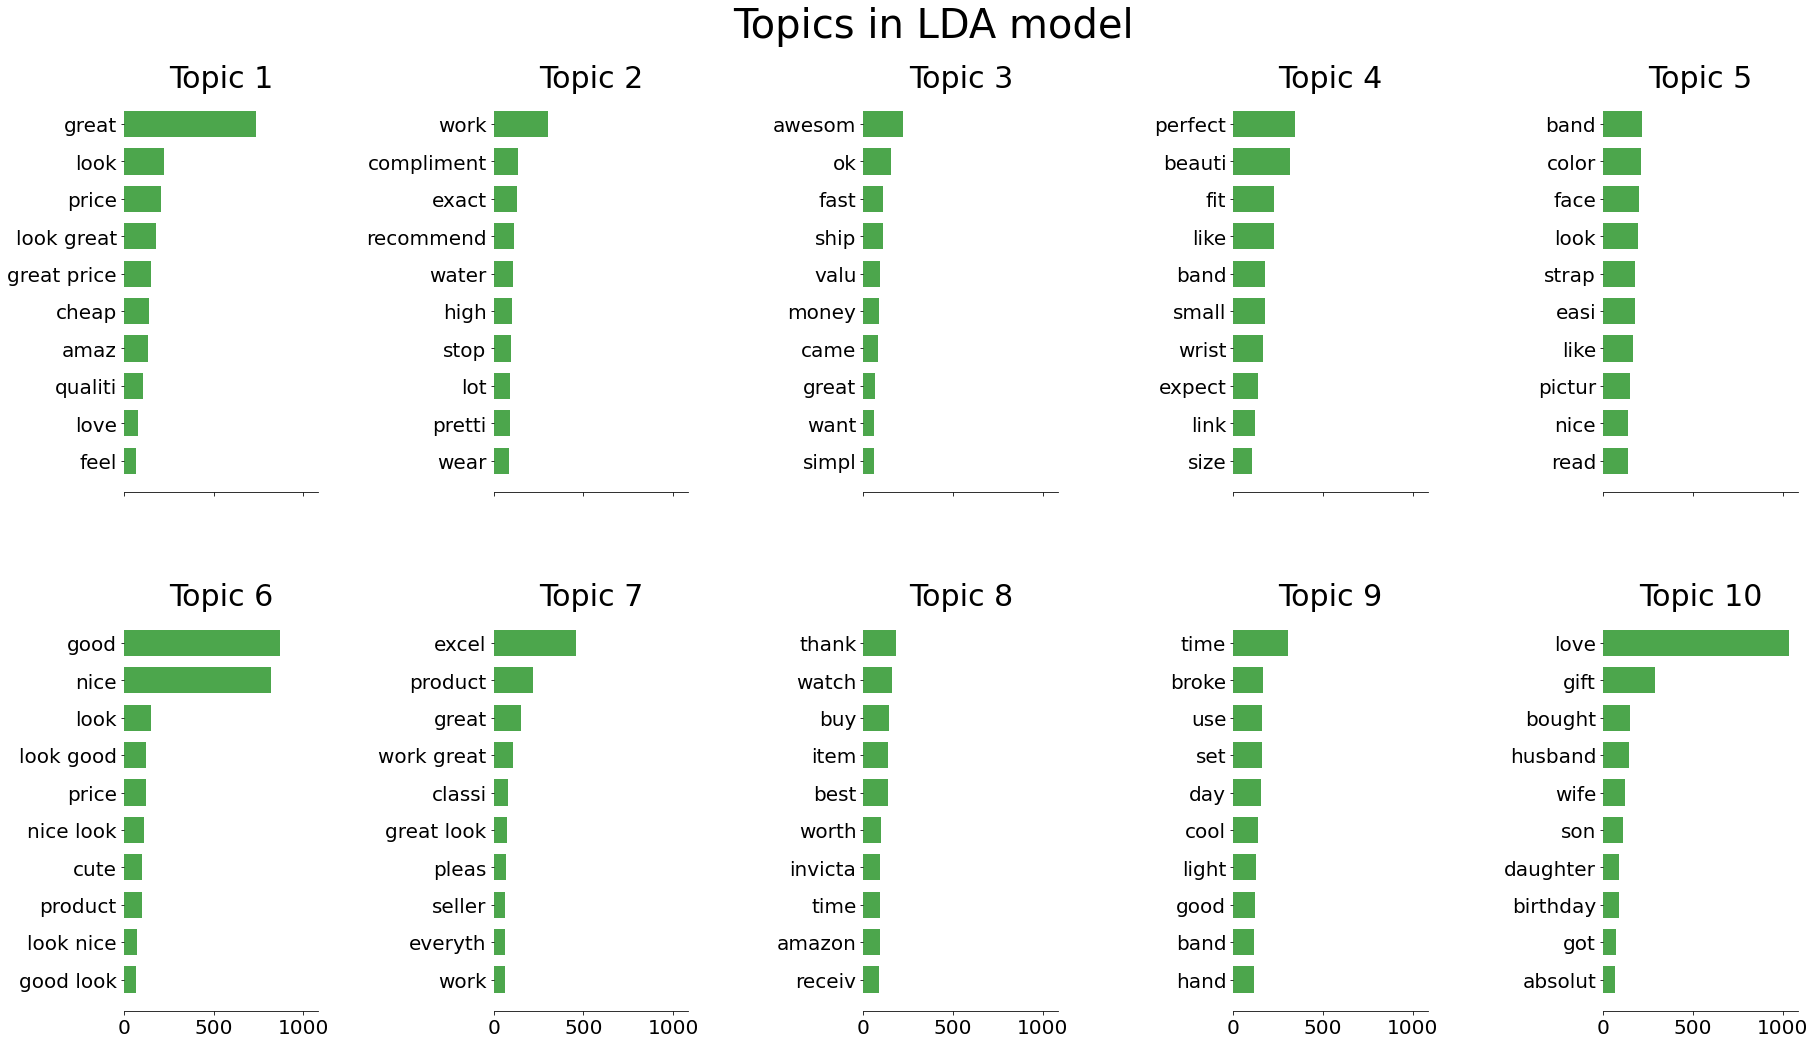

In [67]:
n_top_words = 10
tfidf_feature_names = tfidf_model.get_feature_names_out()

list_top_words(
    lda,
    tfidf_feature_names,
    n_top_words,
    "Topics in LDA model",
)

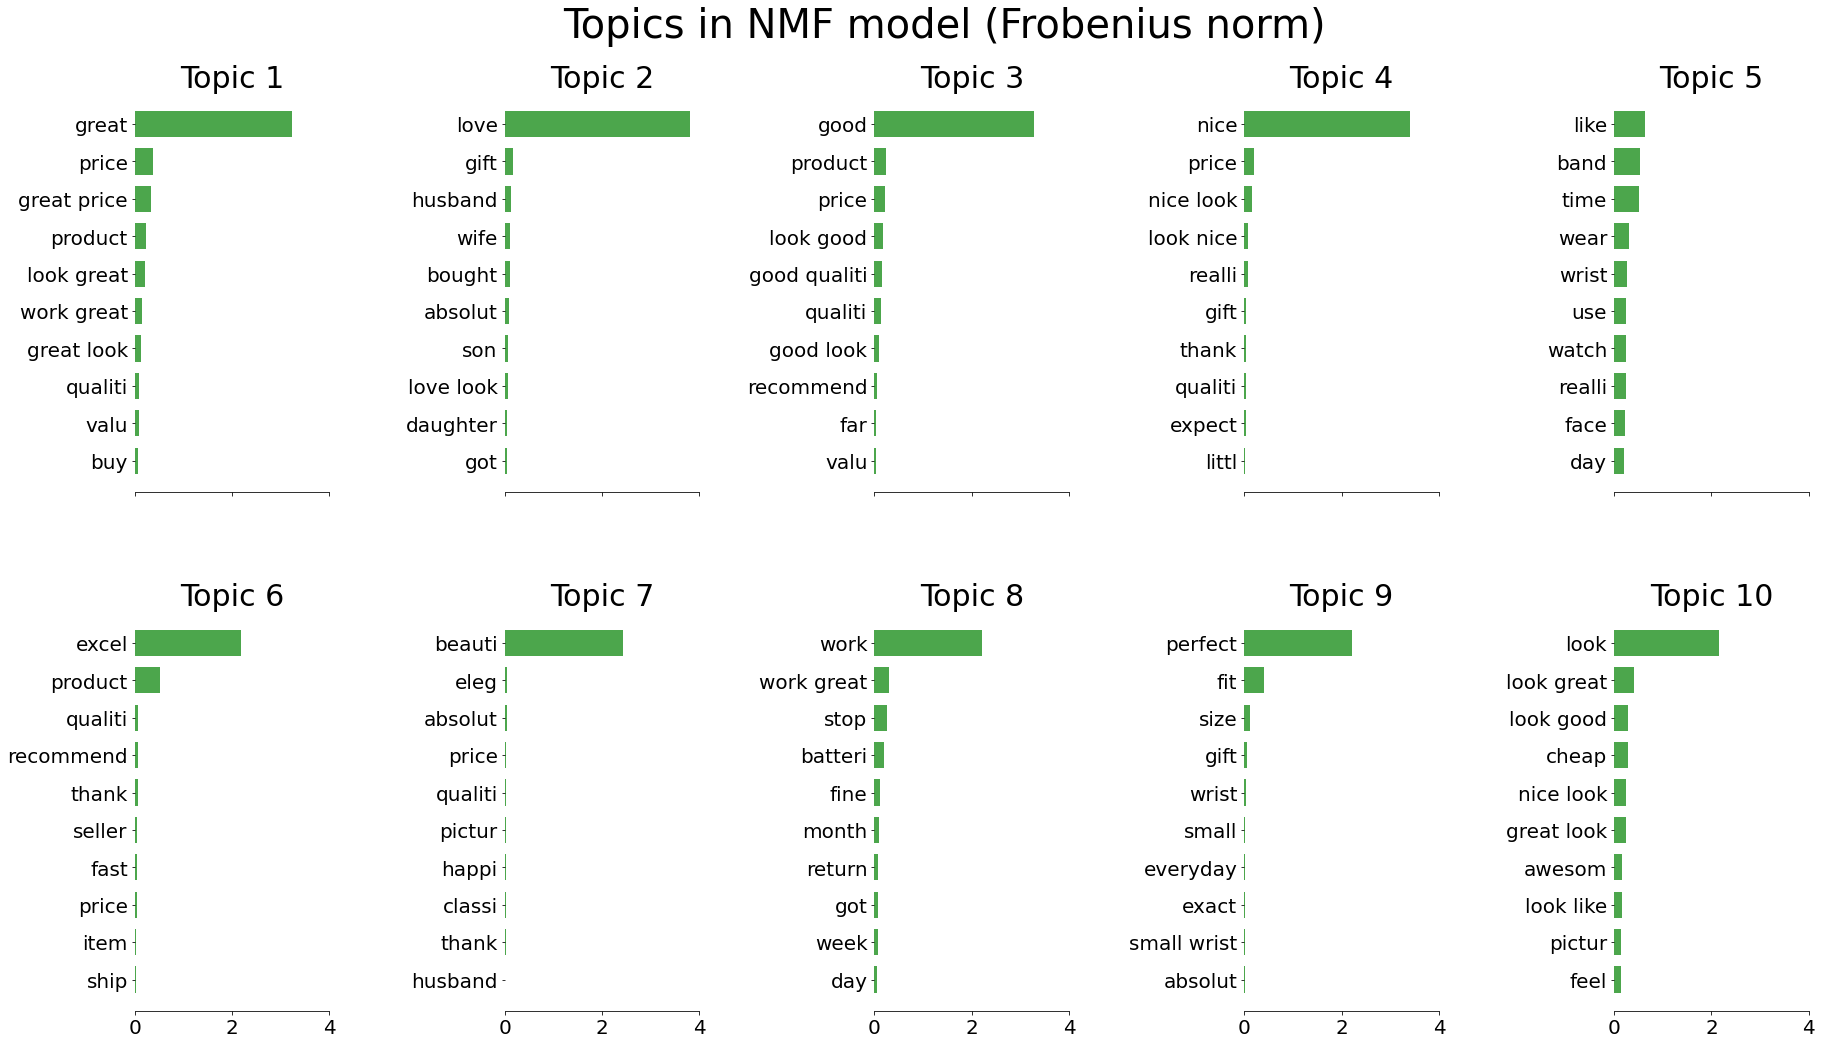

In [68]:
list_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (Frobenius norm)",
)

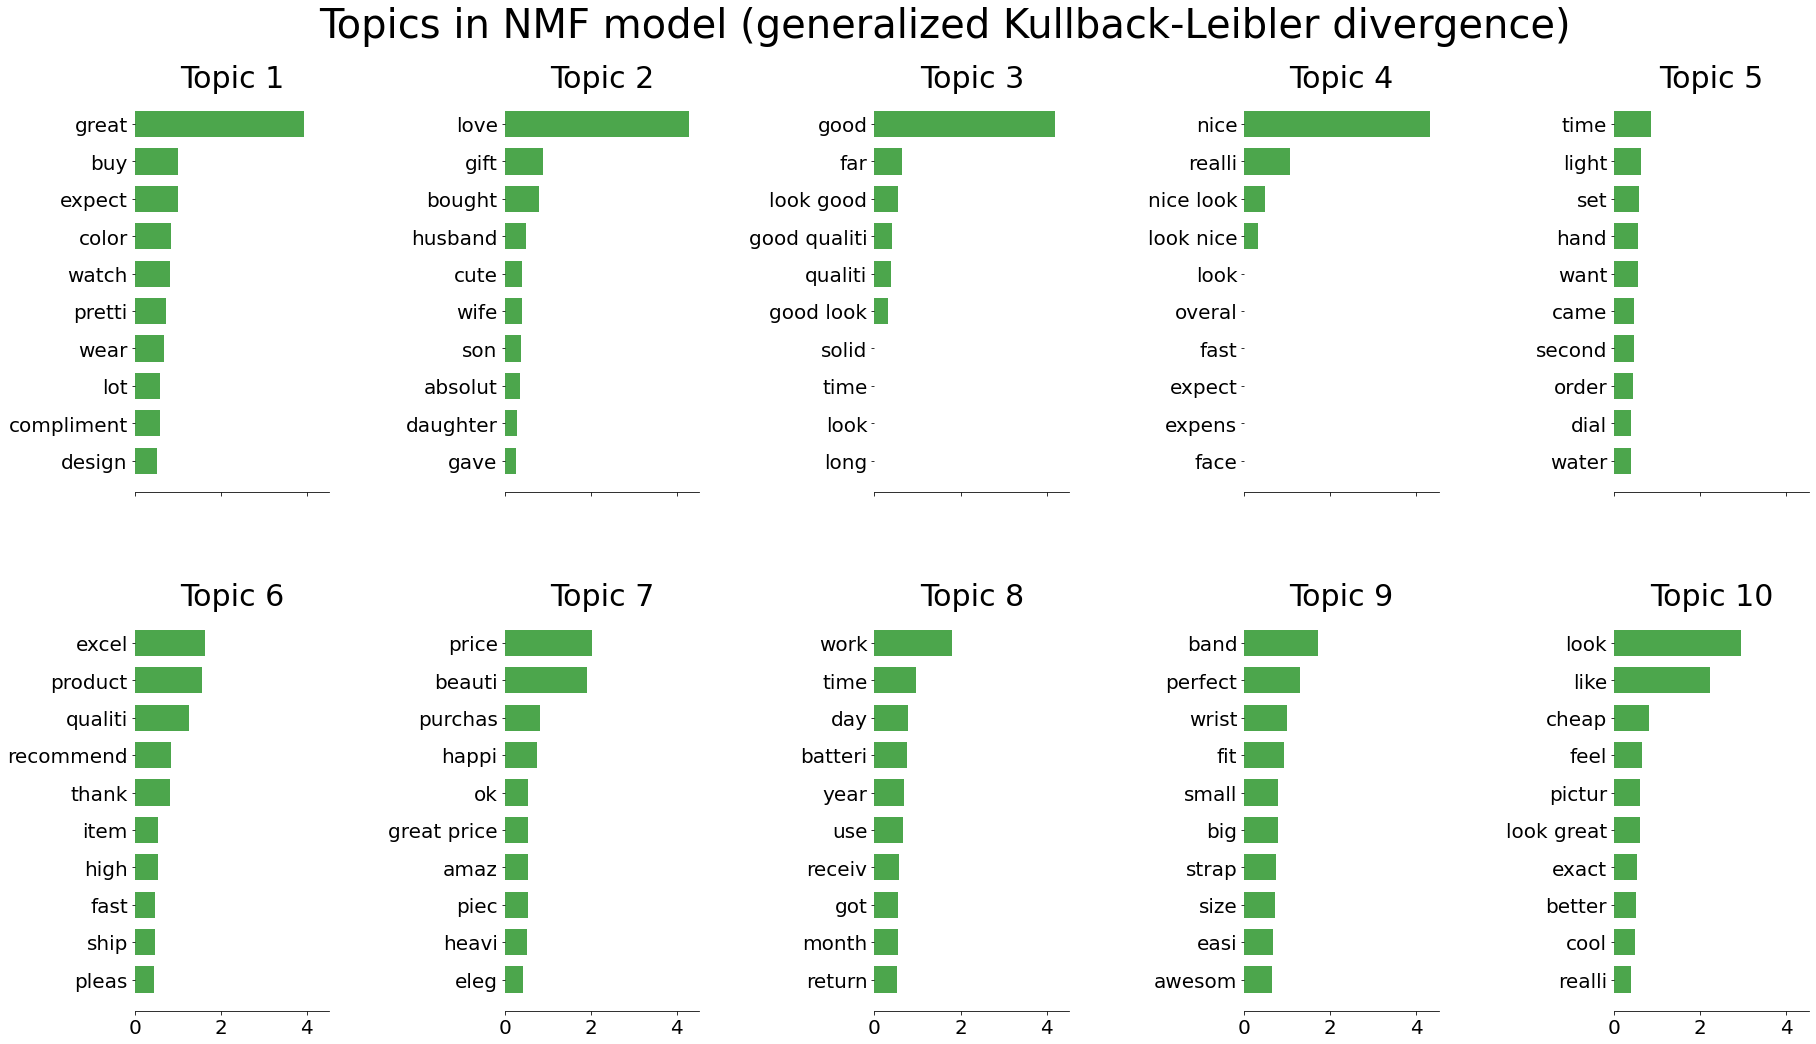

In [73]:
list_top_words(
    nmf_kl,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

#Summary
#It seems that NMF did a better job.